<a href="https://colab.research.google.com/github/asyria/dectectron2-Drone/blob/main/Detectron2_drone_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 라이브러리

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from google.colab.patches import cv2_imshow
import cv2
from IPython.display import HTML
from IPython.display import clear_output, Image
import matplotlib.patches as patches
from IPython.display import clear_output
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# 2. 데이터

Dataset 불러오기

In [14]:
!git clone https://github.com/asyria/dectectron2-Drone

Cloning into 'dectectron2-Drone'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 8452 (delta 2), reused 11 (delta 1), pack-reused 8439
Receiving objects: 100% (8452/8452), 435.79 MiB | 43.51 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (8454/8454), done.


COCO Instances 등록

In [4]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

register_coco_instances("my_dataset_train", {}, "/content/dectectron2-Drone/Dataset/train/coco.json", "/content/dectectron2-Drone/Dataset/train")
register_coco_instances("my_dataset_val", {}, "/content/dectectron2-Drone/Dataset/val/coco.json", "/content/dectectron2-Drone/Dataset/val")
register_coco_instances("my_dataset_test", {}, "/content/dectectron2-Drone/Dataset/test/coco.json", "/content/dectectron2-Drone/Dataset/test")

dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
drone_metadata_train = MetadataCatalog.get("my_dataset_train")

dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
drone_metadata_val = MetadataCatalog.get("my_dataset_val")

dataset_dicts_test = DatasetCatalog.get("my_dataset_test")
drone_metadata_test = MetadataCatalog.get("my_dataset_test")

WARNING [12/17 21:01:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/17 21:01:11 d2.data.datasets.coco]: Loaded 3022 images in COCO format from /content/dectectron2-Drone/Dataset/train/coco.json
WARNING [12/17 21:01:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/17 21:01:11 d2.data.datasets.coco]: Loaded 800 images in COCO format from /content/dectectron2-Drone/Dataset/val/coco.json
WARNING [12/17 21:01:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/17 21:01:11 d2.data.datasets.coco]: Loaded 400 images in COCO format from /content/dectectron2-Drone/Dataset/test/coco.json


등록 확인

WARNING [12/17 21:01:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/17 21:01:14 d2.data.datasets.coco]: Loaded 3022 images in COCO format from /content/dectectron2-Drone/Dataset/train/coco.json


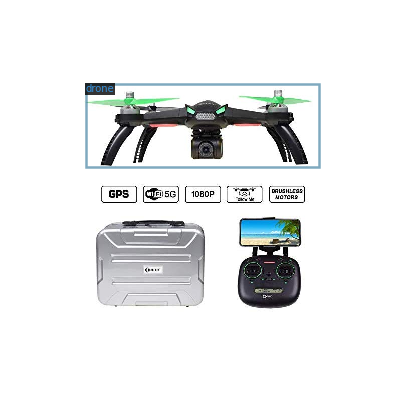

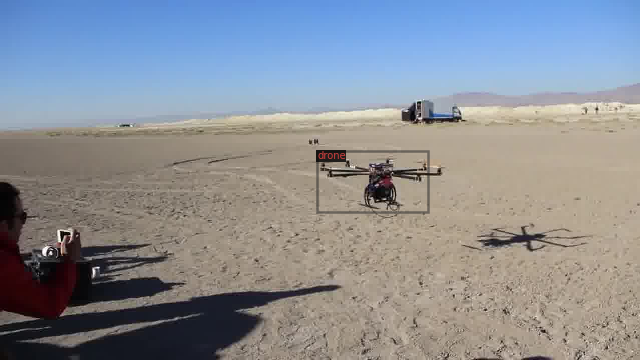

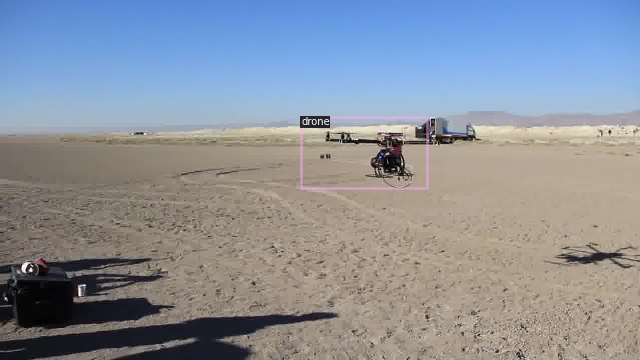

In [5]:
dataset_dicts = DatasetCatalog.get("my_dataset_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=drone_metadata_train, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# 학습

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import logging

# faster_rcnn_R_50_FPN_3x

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.SOLVER.BASE_LR = 0.001  # @ pick a good LR
cfg.SOLVER.MAX_ITER = 1200    # @ 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # @ faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 카테고리 수
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # 임계값

cfg.DATASETS.TEST = ( "my_dataset_val",) 
cfg.TEST.EVAL_PERIOD = 300

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# https://detectron2.readthedocs.io/modules/config.html#detectron2.config.CfgNode
# 훈련 중 데이터 증가에 사용되는 이미지 뒤집기 모드
# [ "horizontal,"vertical ","none "] 중 하나 선택
# _C.INPUT.RANDOM_FLIP = "horizontal"

# detectron2에서 epoch입니다 MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES

#소스 코드 에 따르면 Detectron2 용어의 반복은 epoch. 최적 손실률 / 훈련 시간 비율을 선택하여 실험적으로 최적 MAX_ITER값을 찾아야 합니다


In [9]:
a = cfg.dump()
text_file = open("output/cfg.yaml", "w")
text_file.write(a)
text_file.close()

# 성능 검사

tensorboard 확인

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

COCO Evaluator

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/") # (coco경로, tasks(작업?), distributed(분산), output_dir )
val_loader = build_detection_test_loader(cfg, "my_dataset_test") # (dataset(DatasetCatalog.get()또는 get_detection_dataset_dicts().), *, mapper)
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [12/17 21:24:02 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
WARNING [12/17 21:24:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/17 21:24:02 d2.data.datasets.coco]: Loaded 400 images in COCO format from /content/dectectron2-Drone/Dataset/test/coco.json
[12/17 21:24:02 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   drone    | 468          |
|            |              |
[12/17 21:24:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/17 21:24:02 d2.data.common]: Serializing 400 elements to byte tensors and concatenating them all ...
[12/17 21:24:02 d2.data.common]: Serialized dataset takes 0.10 MiB
[12/17 21:24:02 d2.evalu

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[12/17 21:24:14 d2.evaluation.evaluator]: Inference done 83/400. 0.1386 s / img. ETA=0:00:44


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[12/17 21:24:19 d2.evaluation.evaluator]: Inference done 120/400. 0.1361 s / img. ETA=0:00:39
[12/17 21:24:24 d2.evaluation.evaluator]: Inference done 153/400. 0.1397 s / img. ETA=0:00:35
[12/17 21:24:30 d2.evaluation.evaluator]: Inference done 186/400. 0.1420 s / img. ETA=0:00:31
[12/17 21:24:35 d2.evaluation.evaluator]: Inference done 219/400. 0.1437 s / img. ETA=0:00:26
[12/17 21:24:40 d2.evaluation.evaluator]: Inference done 252/400. 0.1450 s / img. ETA=0:00:21
[12/17 21:24:45 d2.evaluation.evaluator]: Inference done 285/400. 0.1461 s / img. ETA=0:00:17
[12/17 21:24:50 d2.evaluation.evaluator]: Inference done 317/400. 0.1469 s / img. ETA=0:00:12
[12/17 21:24:55 d2.evaluation.evaluator]: Inference done 349/400. 0.1477 s / img. ETA=0:00:07
[12/17 21:25:00 d2.evaluation.evaluator]: Inference done 381/400. 0.1483 s / img. ETA=0:00:02
[12/17 21:25:03 d2.evaluation.evaluator]: Total inference time: 0:00:59.689733 (0.151113 s / img per device, on 1 devices)
[12/17 21:25:03 d2.evaluation.e

# 모델 응용 (드론 탐지 및 식별)

모델 불러오기

In [15]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file("/content/output/cfg.yaml") # @
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/model_final.pth")  #  @path to the model we just trained
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # @set a custom testing threshold
predictor = DefaultPredictor(cfg)

히스토그램 추출

In [16]:
def histogram3D(img):
	# 3차원 히스토그램 계산
	hist = cv2.calcHist( [img], [0, 1, 2], None, [32, 32, 32], [0, 256, 0, 256, 0, 256] )
	hist = cv2.normalize(hist, hist)

	# 결과 히스토그램 반환
	return hist

ID Class

In [21]:
class Instances :
  instances = []
  def __init__(self):
    self.instances = []
    self.idx = 1

  def append(self, hist, cxcy):
    temp = [self.idx, hist, cxcy]
    self.instances.append(temp)
    self.idx += 1

  def compare(self, hist, cxcy):
    temp = []
    temp2 = [] # 최종 instance
    test : float
    for instance in self.instances:
      var = cv2.compareHist(instance[1], hist, cv2.HISTCMP_CORREL)
      test = var
      if (var > 0.7):
        temp.append(instance)

    #print("확인4",temp)
    if not temp:
      print("유사한 객체없음 새로운 객체로 인식")
      print("유사도 : ",test)
      self.append(hist, cxcy )
      return self.instances[len(self.instances)-1]
        
    #print("확인3",temp)
    for index,instance in enumerate(temp) :
      cx2 = instance[2][0]
      cy2 = instance[2][1] # 정규화된 x,y 좌표

      cx1 = cxcy[0]
      cy1 = cxcy[1]

      # 두 점 거리
      var = math.sqrt((cx2-cx1)*(cx2-cx1) + (cy2-cy1)*(cy2-cy1))
      #print(index)
      #print("확인1",instance)
      if index is 0 :
        ab = var
        temp2 = instance
      if (var < ab):
        ab = var
        temp2 = instance

    #print("확인2",temp2)
    # temp2[0] 과 같은 idx를 가진 instances를 찾아서 해당 instances의 hist = (hist + _hist) /2, cxcy = _cxcy
    for idx,instance in enumerate(self.instances) :
      if(temp2[0] == instance[0]):
        self.instances[idx][1] = (self.instances[idx][1] + hist)/2
        self.instances[idx][2] = cxcy

    return temp2



동영상에 적용

In [22]:
import cv2
import math
from detectron2.utils.visualizer import ColorMode

# 재생할 파일 
# VIDEO_FILE_PATH = '/content/gdrive/MyDrive/Dataset/V_DRONE_072.mp4'
# VIDEO_FILE_PATH = '/content/Multiple Drone2.mkv'
VIDEO_FILE_PATH = '/content/dectectron2-Drone/Test Video/V_DRONE_072.mp4'
# VIDEO_FILE_PATH = '/content/drone.mp4'

# 동영상 파일 열기
cap = cv2.VideoCapture(VIDEO_FILE_PATH)

# 잘 열렸는지 확인
if cap.isOpened() == False:
  print ('Can\'t open the video (%d)' % (VIDEO_FILE_PATH))
  exit()
else :
  print("open video")

# 재생할 파일의 넓이 얻기
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
# 재생할 파일의 높이 얻기
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
# 재생할 파일의 프레임 레이트 얻기
fps:int = cap.get(cv2.CAP_PROP_FPS)

print('width {0}, height {1}, fps {2}'.format(width, height, fps))

# XVID가 제일 낫다고 함.
#linux 계열 DIVX, XVID, MJPG, X264, WMV1, WMV2.
#windows 계열 DIVX
#저장할 비디오 코덱
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
#저장할 파일 이름
filename = 'output.avi'

# 파일 stream 생성
# out = cv2.VideoWriter(filename, fourcc, fps, (int(width), int(height)))
out = cv2.VideoWriter(filename, fourcc, 30, (int(width), int(height)))
#filename : 파일 이름
#fourcc : 코덱
#fps : 초당 프레임 수
#width : 넓이
#height : 높이

instances = Instances()
count = 0
while(True):
    # 파일로 부터 이미지 얻기
    ret, frame = cap.read()
    # 더 이상 이미지가 없으면 종료
    if frame is None:
        break;
  
    # 프레임 수 조절
    if(count>=0) :
      #print(count)
      visualizer = Visualizer(frame[:, :, ::-1],
                    #metadata=drone_metadata_train, 
                    scale=1, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
          )
      image_result = frame
      # 프레임에 모델 적용
      outputs = predictor(frame)
      # 탐지된 객체가 있으면 :
      if(outputs['instances']) :
        #print("인스턴스 확인")
        for i in range(len(outputs['instances'])) :
          # 각 인스턴스에 대해 히스토그램 작업
          # instnace = [instnaces_idx, [hist], [cx,cy]]
          #print("{} 번째 인스턴스".format(i+1))
          boxes = outputs['instances'][i].pred_boxes.tensor.cpu().numpy()
          #print(boxes)
          x1 = math.ceil(boxes[0][0])
          y1 = math.ceil(boxes[0][1])
          x2 = math.ceil(boxes[0][2])
          y2 = math.ceil(boxes[0][3])

          crop_img = frame[y1:y2,x1:x2]

          # cx, cy
          cx:float = (x1+x2)/2 /width
          cy:float = (y1+y2)/2 /height
          # hist
          hist = histogram3D(crop_img)

          # 비교
          # 비교할 instance가 없으면
          if not instances.instances :
            print("instances가 없습니다.")
            instances.append(hist, [cx,cy])
          # instances.[i][1] 과 비교
          # 유사도 > 0.8면 유사한 instnace로 인식, temp_instance = instance[i]
          # cx,cy와 instances.[i][2] 거리 계산
          temp = instances.compare(hist, [cx,cy])
          # 프레임에 각 인스탠스 box 그림
          #visualizer = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
          image_instance = visualizer.draw_box(outputs['instances'][i].pred_boxes.tensor.cpu().numpy()[0],0.5,'g','-')
          image_instance = visualizer.draw_text("drone_{}".format(temp[0]),(x1+15,y1))
          image_result = image_instance.get_image()[:, :, ::-1]
          

        #break;

    
    #plt.imshow(image_result)
    # 인식된 이미지 파일로 저장
    out.write(image_result)  
    count+=1
    #plt.show()

#plt.show()
#재생 파일 종료
cap.release()
#저장 파일 종료
out.release()



open video
width 640.0, height 512.0, fps 30.0
instances가 없습니다.
유사한 객체없음 새로운 객체로 인식
유사도 :  0.6467980369864417
